In [3]:
import sys
import os

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
from scipy.interpolate import CubicSpline
import awkward
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from numba import jit


date and time: 02092025


In [4]:
# Copied functions from ELOSS

Z = 18
A = 39.948   # g / mol
I = 188.0*(10**(-6)) # MeV
K = 0.307 # MeV * cm^2 / mol
Mmu = 105.658 # MeV for muon
Me  = 0.51 # MeV for electron
rho = 1.396 # g/cm3

@jit(nopython=True)
def beta(gamma):
    return np.sqrt(1-(1./(gamma**2)))

@jit(nopython=True)
def gamma(KE,mass):
    return (KE/mass)+1

@jit(nopython=True)
def Wmax (KE,mass):
    g = gamma(KE,mass)
    b = beta(g)
    num = 2*Me*((b*g)**2)
    den = 1 + 2*g*Me/mass + (Me/mass)**2
    return num/den

@jit(nopython=True)
def density(bg):

    
    C  = -5.2146
    X0 = 0.2
    X1 = 3.0
    a  = 0.19559
    m  = 3.0
    N    = 2 * np.log(10)
    
    x = np.log10(bg)
    addition = a*((X1-x)**m)
    return np.where(
        x < X0, 0.0,
        np.where(x > X1, N * x + C, N * x + C + a * ((X1 - x) ** m))
    )


    
# KE in MeV
# x in cm
# mass in MeV
@jit(nopython=True)
def dpdx(KE,x,mass,I=I):
    g = gamma(KE,mass)
    b = beta(g)
    epsilon = (K/2.)*(Z/A)*(x*rho/(b*b))
    A0 = (2*Me*(b*g)**2)/I
    A1 = epsilon/I
    return (1./x) * epsilon * (np.log(A0) + np.log(A1) + 0.2 - (b*b) - density(b*g))

# in MeV/cm
@jit(nopython=True)
def dedx(KE,mass,I=I,dens=True):
    g = gamma(KE,mass)
    b = beta(g)
    F = K * (Z/A)*(1/b)**2
    wmax = Wmax(KE,mass)
    a0 = 0.5*np.log( 2*Me*(b*g)**2 * wmax / (I*I) )
    ret = a0 - b*b
    if (dens == True):
        ret -= density(b*g)/2.
    return F * ret


@jit(nopython=True)
def KE_from_Range(R,mass,stepmax):
    KE = 0.3 # MeV
    dist = 0.
    thisstep = 1e-3        
    while ((dist+thisstep) < R):
        eloss = rho * dedx(KE,mass,dens=True)
        KE += (eloss * thisstep)
        dist += thisstep

        if ((thisstep < dist/10.) and (dist/10. < stepmax)):
            thisstep = dist/10.
    return KE

MASS_M = 105.658
STEP = 0.1
PITCH = 0.3




In [5]:
variables = ['run','evt','ntrack','longest','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y',\
             'reco_nu_vtx_sce_z','trk_sce_start_x','trk_sce_start_y','trk_sce_start_z',\
            'trk_sce_end_x','trk_sce_end_y','trk_sce_end_z','trk_llr_pid_score',\
            'trk_llr_pid_u','trk_llr_pid_v','trk_llr_pid_y',\
            'dqdx_u','dqdx_v','dqdx_y','dedx_u','dedx_v','dedx_y',\
            'rr_u','rr_v','rr_y','pitch_u','pitch_v','pitch_y']

DATA = uproot.open("/Users/jimji/Recom_code/data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19.root")['nuselection']['CalorimetryAnalyzer']
DF_DATA = DATA.arrays(variables, library="pd", how="zip")

In [6]:
# select only muons
DF_MUONS = DF_DATA.query('trk_llr_pid_score > 0. and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons = np.array([])
dqdx_y_v_Muons = np.array([])
pid_score_M = np.array([])

for index,entry in DF_MUONS.iterrows():
    pid_score_M = np.concatenate((pid_score_M, entry['trk_llr_pid_score']), axis=None)
    rr_y_v_Muons = np.concatenate((rr_y_v_Muons,entry['rr_y']),axis=None)
    dqdx_y_v_Muons = np.concatenate((dqdx_y_v_Muons,entry['dqdx_y']),axis=None)


print(len(rr_y_v_Muons), len(dqdx_y_v_Muons),len(pid_score_M))

1739719 1739719 6502


In [7]:

KE = np.array([KE_from_Range(r, MASS_M, STEP) for r in rr_y_v_Muons])
dEdx_Muons = np.array([dedx(ke, MASS_M, I=I, dens=True) for ke in KE])

print(len(dEdx_Muons))

1739719


In [8]:
DF_MUONS = DF_DATA.query('trk_llr_pid_score > 0.95 and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons = np.array([])
dqdx_y_v_Muons = np.array([])
pid_score_M = np.array([])

for index,entry in DF_MUONS.iterrows():
    rr_y_v_Muons = np.concatenate((rr_y_v_Muons,entry['rr_y']),axis=None)
    dqdx_y_v_Muons = np.concatenate((dqdx_y_v_Muons,entry['dqdx_y']),axis=None)


print(len(rr_y_v_Muons), len(dqdx_y_v_Muons))

928646 928646


In [9]:
KE = np.array([KE_from_Range(r, MASS_M, STEP) for r in rr_y_v_Muons])
dEdx_Muons = np.array([dedx(ke, MASS_M, I=I, dens=True) for ke in KE])

print(len(dEdx_Muons))


928646


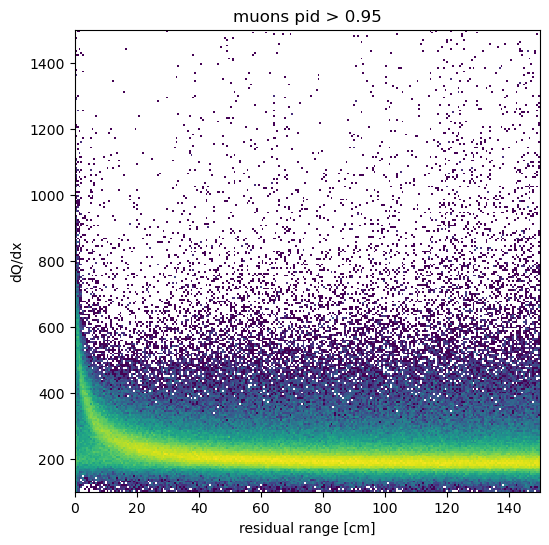

In [10]:
# Plot the curve of dQ/dx against RR for Muons
fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(0,150,250),np.linspace(100,1500,250))
plt.hist2d(rr_y_v_Muons,dqdx_y_v_Muons,bins=BINS2D,norm=colors.LogNorm())
plt.xlabel('residual range [cm]')
plt.ylabel('dQ/dx')
plt.title('muons pid > 0.95')
plt.show()

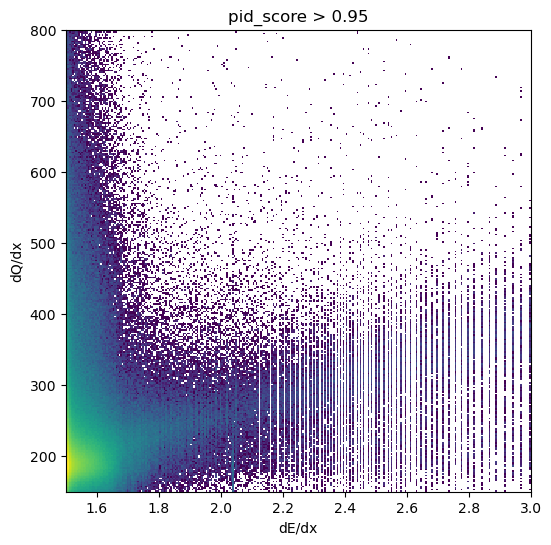

928646


In [11]:
BINS2D = (np.linspace(1.5, 3, 300), np.linspace(150, 800, 300))
fig = plt.figure(figsize=(6,6))
plt.hist2d(dEdx_Muons, dqdx_y_v_Muons, bins=BINS2D, norm=colors.LogNorm())
plt.xlabel('dE/dx')
plt.ylabel('dQ/dx')
plt.title('pid_score > 0.95')
plt.show()

print(len(dEdx_Muons))
